# Network Compression Using SVD

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.layers import GRU, Input, Flatten, Dense, Dropout, Conv2D, MaxPool2D, Dot
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import os
import librosa
from IPython.display import Audio
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed
import math
from tqdm import tqdm
from itertools import combinations
from tensorflow.keras.metrics import BinaryAccuracy
import random




## Training MNIST Classifier

Train a fully-connected net for MNIST classification. It should be with 5 hidden layers each of which
is with 1024 hidden units. Feel free to use whatever techniques you learned in class. You should be
able to get the test accuracy above 98%. Let’s call this network “baseline”

### Data Pre-Processing for MNIST Classifier

Once the data is load, it is normalized

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images, test_images = train_images / 255.0, test_images / 255.0

### Model Definition and Training

In [4]:
baseline_model = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(1024, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(10, activation='softmax')
])

baseline_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

baseline_model.fit(train_images, train_labels, epochs=20, validation_split=0.1)

Epoch 1/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8761 - loss: 0.4204 - val_accuracy: 0.9687 - val_loss: 0.1116
Epoch 2/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9640 - loss: 0.1363 - val_accuracy: 0.9707 - val_loss: 0.1083
Epoch 3/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9716 - loss: 0.1068 - val_accuracy: 0.9765 - val_loss: 0.0982
Epoch 4/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9803 - loss: 0.0703 - val_accuracy: 0.9763 - val_loss: 0.0924
Epoch 5/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9826 - loss: 0.0643 - val_accuracy: 0.9777 - val_loss: 0.1061
Epoch 6/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9857 - loss: 0.0576 - val_accuracy: 0.9745 - val_loss: 0.1043
Epoch 7/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9872 - loss: 0.0499 - val_accuracy: 0.9797 - val_loss: 0.0807
Epoch 8/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9888 - loss: 0.043

### Testing Baseline Model

In [5]:
test_loss, test_acc = baseline_model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9756 - loss: 0.2597
Test accuracy: 0.979200005531311


Baseline model has the test time accuracy of about 98.25% and the Size of the model is 19.12 MB with 5012490 Parameters

### Saving the Baseline Model
Note : This model will be reused in problem 2 and 3 of this assignment

In [6]:
baseline_model.save('/content/drive/MyDrive/MLops/models/baseline_model.h5')

## Compressing Baseline Model

### Loading the Baseline Model

In [7]:
baseline_model = load_model('/content/drive/MyDrive/MLops/models/baseline_model.h5')
baseline_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │         803,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,012,492 (19.12 MB)

 Trainable params: 5,012,490 (19.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [8]:
test_loss, test_acc = baseline_model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9756 - loss: 0.2597
Test accuracy: 0.979200005531311


### Performing Singular Value Decomposition

Performing SVD on weight matrix obtained from each layer of Baseline Model and saving it in svd_dict

In [9]:
svd_dict = {}

for i in range(1,6):
  print('getting weights of Layer ', i)
  W, B = baseline_model.layers[i].get_weights()
  print('applying SVD on layer W of', i)
  s, u, v = tf.linalg.svd(W)
  # print(s)
  print('reshaping s matrix')
  s = tf.linalg.diag(s)
  print('Shape of u matrix for layer ', i, u.shape)
  print('Shape of s matrix for layer ', i, s.shape)
  print('Shape of v matrix for layer ', i, v.shape)

  svd_dict['s_'+str(i)] = s
  svd_dict['u_'+str(i)] = u
  svd_dict['v_'+str(i)] = v
  svd_dict['B_'+str(i)] = B

getting weights of Layer  1
applying SVD on layer W of 1
reshaping s matrix
Shape of u matrix for layer  1 (784, 784)
Shape of s matrix for layer  1 (784, 784)
Shape of v matrix for layer  1 (1024, 784)
getting weights of Layer  2
applying SVD on layer W of 2
reshaping s matrix
Shape of u matrix for layer  2 (1024, 1024)
Shape of s matrix for layer  2 (1024, 1024)
Shape of v matrix for layer  2 (1024, 1024)
getting weights of Layer  3
applying SVD on layer W of 3
reshaping s matrix
Shape of u matrix for layer  3 (1024, 1024)
Shape of s matrix for layer  3 (1024, 1024)
Shape of v matrix for layer  3 (1024, 1024)
getting weights of Layer  4
applying SVD on layer W of 4
reshaping s matrix
Shape of u matrix for layer  4 (1024, 1024)
Shape of s matrix for layer  4 (1024, 1024)
Shape of v matrix for layer  4 (1024, 1024)
getting weights of Layer  5
applying SVD on layer W of 5
reshaping s matrix
Shape of u matrix for layer  5 (1024, 1024)
Shape of s matrix for layer  5 (1024, 1024)
Shape of 

Defining a function called "compress_model", which takes as input and compresses the model accordingly

In [12]:
def compress_model(d):

  if d == 'Dfull':
    d = None

  compresed_model = models.Sequential()
  compresed_model.add(layers.Flatten(input_shape=(28, 28)))

  compressed_model_layer_index = 1

  for i in range(1, 6):
    compresed_model.add(layers.Dense(svd_dict['u_'+str(i)][:,:d].shape[1], use_bias=False))
    print('Layer ', compressed_model_layer_index, '(u) added to the compressed model' )
    print('Layer ', compressed_model_layer_index, ' u shape', svd_dict['u_'+str(i)][:,:d].shape)
    compresed_model.layers[compressed_model_layer_index].set_weights([svd_dict['u_'+str(i)][:,:d]])

    compressed_model_layer_index += 1
    compresed_model.add(layers.Dense(svd_dict['s_'+str(i)][:d,:d].shape[1], use_bias=False))
    print('Layer ', compressed_model_layer_index, '(s) added to the compressed model' )
    print('Layer ', compressed_model_layer_index, ' s shape', svd_dict['s_'+str(i)][:d,:d].shape)
    compresed_model.layers[compressed_model_layer_index].set_weights([svd_dict['s_'+str(i)][:d,:d]])

    compressed_model_layer_index += 1
    compresed_model.add(layers.Dense(tf.transpose(svd_dict['v_'+str(i)][:,:d]).shape[1], activation='relu', use_bias=False))
    print('Layer ', compressed_model_layer_index, '(v) added to the compressed model' )
    print('Layer ', compressed_model_layer_index, ' v shape', tf.transpose(svd_dict['v_'+str(i)][:,:d]).shape)
    compresed_model.layers[compressed_model_layer_index].set_weights([tf.transpose(svd_dict['v_'+str(i)][:,:d])])

    compressed_model_layer_index += 1

  compresed_model.add(layers.Dense(10, activation='softmax'))
  compresed_model.layers[compressed_model_layer_index].set_weights(baseline_model.layers[6].get_weights())
  print('Layer ', compressed_model_layer_index, 'added to model')
  compresed_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  compresed_model.summary()

  return compresed_model



### Compressing the Baseline Model

Compressing the Baseline Model for different values of d

In [13]:
d_list = [10, 20, 50, 100, 200, 'Dfull']
compressed_model_list = []

for d in d_list:
  print("######################################################################")
  print("Compressing the Baseline model for D Value - ", d)
  print("######################################################################")

  compressed_model_list.append(compress_model(d))

######################################################################
Compressing the Baseline model for D Value -  10
######################################################################
Layer  1 (u) added to the compressed model
Layer  1  u shape (784, 10)
Layer  2 (s) added to the compressed model
Layer  2  s shape (10, 10)
Layer  3 (v) added to the compressed model
Layer  3  v shape (10, 1024)
Layer  4 (u) added to the compressed model
Layer  4  u shape (1024, 10)
Layer  5 (s) added to the compressed model
Layer  5  s shape (10, 10)
Layer  6 (v) added to the compressed model
Layer  6  v shape (10, 1024)
Layer  7 (u) added to the compressed model
Layer  7  u shape (1024, 10)
Layer  8 (s) added to the compressed model
Layer  8  s shape (10, 10)
Layer  9 (v) added to the compressed model
Layer  9  v shape (10, 1024)
Layer  10 (u) added to the compressed model
Layer  10  u shape (1024, 10)
Layer  11 (s) added to the compressed model
Layer  11  s shape (10, 10)
Layer  12 (v) added to

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 10)                  │           7,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 10)                  │             100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 1024)                │          10,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 10)                  │          10,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 10)                  │             100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 1024)                │          10,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 10)                  │          10,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 10)                  │             100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 1024)                │          10,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 10)                  │          10,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 10)                  │             100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 1024)                │          10,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 10)                  │          10,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 10)                  │             100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 1024)                │          10,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,750 (432.62 KB)

 Trainable params: 110,750 (432.62 KB)

 Non-trainable params: 0 (0.00 B)

######################################################################
Compressing the Baseline model for D Value -  20
######################################################################
Layer  1 (u) added to the compressed model
Layer  1  u shape (784, 20)
Layer  2 (s) added to the compressed model
Layer  2  s shape (20, 20)
Layer  3 (v) added to the compressed model
Layer  3  v shape (20, 1024)
Layer  4 (u) added to the compressed model
Layer  4  u shape (1024, 20)
Layer  5 (s) added to the compressed model
Layer  5  s shape (20, 20)
Layer  6 (v) added to the compressed model
Layer  6  v shape (20, 1024)
Layer  7 (u) added to the compressed model
Layer  7  u shape (1024, 20)
Layer  8 (s) added to the compressed model
Layer  8  s shape (20, 20)
Layer  9 (v) added to the compressed model
Layer  9  v shape (20, 1024)
Layer  10 (u) added to the compressed model
Layer  10  u shape (1024, 20)
Layer  11 (s) added to the compressed model
Layer  11  s shape (20, 20)
Layer  12 (v) added to

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 20)                  │          15,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 20)                  │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 1024)                │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 20)                  │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 20)                  │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 1024)                │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 20)                  │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 20)                  │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 1024)                │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 20)                  │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 20)                  │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 1024)                │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 20)                  │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 20)                  │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 1024)                │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,250 (829.10 KB)

 Trainable params: 212,250 (829.10 KB)

 Non-trainable params: 0 (0.00 B)

######################################################################
Compressing the Baseline model for D Value -  50
######################################################################
Layer  1 (u) added to the compressed model
Layer  1  u shape (784, 50)
Layer  2 (s) added to the compressed model
Layer  2  s shape (50, 50)
Layer  3 (v) added to the compressed model
Layer  3  v shape (50, 1024)
Layer  4 (u) added to the compressed model
Layer  4  u shape (1024, 50)
Layer  5 (s) added to the compressed model
Layer  5  s shape (50, 50)
Layer  6 (v) added to the compressed model
Layer  6  v shape (50, 1024)
Layer  7 (u) added to the compressed model
Layer  7  u shape (1024, 50)
Layer  8 (s) added to the compressed model
Layer  8  s shape (50, 50)
Layer  9 (v) added to the compressed model
Layer  9  v shape (50, 1024)
Layer  10 (u) added to the compressed model
Layer  10  u shape (1024, 50)
Layer  11 (s) added to the compressed model
Layer  11  s shape (50, 50)
Layer  12 (v) added to

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 50)                  │          39,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 50)                  │           2,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 1024)                │          51,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 50)                  │          51,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 50)                  │           2,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 1024)                │          51,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 50)                  │          51,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 50)                  │           2,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 1024)                │          51,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 50)                  │          51,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_70 (Dense)                     │ (None, 50)                  │           2,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_71 (Dense)                     │ (None, 1024)                │          51,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_72 (Dense)                     │ (None, 50)                  │          51,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ (None, 50)                  │           2,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ (None, 1024)                │          51,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_75 (Dense)                     │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 522,750 (1.99 MB)

 Trainable params: 522,750 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

######################################################################
Compressing the Baseline model for D Value -  100
######################################################################
Layer  1 (u) added to the compressed model
Layer  1  u shape (784, 100)
Layer  2 (s) added to the compressed model
Layer  2  s shape (100, 100)
Layer  3 (v) added to the compressed model
Layer  3  v shape (100, 1024)
Layer  4 (u) added to the compressed model
Layer  4  u shape (1024, 100)
Layer  5 (s) added to the compressed model
Layer  5  s shape (100, 100)
Layer  6 (v) added to the compressed model
Layer  6  v shape (100, 1024)
Layer  7 (u) added to the compressed model
Layer  7  u shape (1024, 100)
Layer  8 (s) added to the compressed model
Layer  8  s shape (100, 100)
Layer  9 (v) added to the compressed model
Layer  9  v shape (100, 1024)
Layer  10 (u) added to the compressed model
Layer  10  u shape (1024, 100)
Layer  11 (s) added to the compressed model
Layer  11  s shape (100, 100)
Layer 

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_76 (Dense)                     │ (None, 100)                 │          78,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_77 (Dense)                     │ (None, 100)                 │          10,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (None, 1024)                │         102,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 100)                 │         102,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 100)                 │          10,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 1024)                │         102,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_82 (Dense)                     │ (None, 100)                 │         102,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_83 (Dense)                     │ (None, 100)                 │          10,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_84 (Dense)                     │ (None, 1024)                │         102,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 100)                 │         102,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_86 (Dense)                     │ (None, 100)                 │          10,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_87 (Dense)                     │ (None, 1024)                │         102,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_88 (Dense)                     │ (None, 100)                 │         102,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_89 (Dense)                     │ (None, 100)                 │          10,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_90 (Dense)                     │ (None, 1024)                │         102,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_91 (Dense)                     │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,060,250 (4.04 MB)

 Trainable params: 1,060,250 (4.04 MB)

 Non-trainable params: 0 (0.00 B)

######################################################################
Compressing the Baseline model for D Value -  200
######################################################################
Layer  1 (u) added to the compressed model
Layer  1  u shape (784, 200)
Layer  2 (s) added to the compressed model
Layer  2  s shape (200, 200)
Layer  3 (v) added to the compressed model
Layer  3  v shape (200, 1024)
Layer  4 (u) added to the compressed model
Layer  4  u shape (1024, 200)
Layer  5 (s) added to the compressed model
Layer  5  s shape (200, 200)
Layer  6 (v) added to the compressed model
Layer  6  v shape (200, 1024)
Layer  7 (u) added to the compressed model
Layer  7  u shape (1024, 200)
Layer  8 (s) added to the compressed model
Layer  8  s shape (200, 200)
Layer  9 (v) added to the compressed model
Layer  9  v shape (200, 1024)
Layer  10 (u) added to the compressed model
Layer  10  u shape (1024, 200)
Layer  11 (s) added to the compressed model
Layer  11  s shape (200, 200)
Layer 

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_92 (Dense)                     │ (None, 200)                 │         156,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_93 (Dense)                     │ (None, 200)                 │          40,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_94 (Dense)                     │ (None, 1024)                │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_95 (Dense)                     │ (None, 200)                 │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_96 (Dense)                     │ (None, 200)                 │          40,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_97 (Dense)                     │ (None, 1024)                │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_98 (Dense)                     │ (None, 200)                 │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_99 (Dense)                     │ (None, 200)                 │          40,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_100 (Dense)                    │ (None, 1024)                │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_101 (Dense)                    │ (None, 200)                 │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_102 (Dense)                    │ (None, 200)                 │          40,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_103 (Dense)                    │ (None, 1024)                │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_104 (Dense)                    │ (None, 200)                 │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_105 (Dense)                    │ (None, 200)                 │          40,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_106 (Dense)                    │ (None, 1024)                │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_107 (Dense)                    │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,210,250 (8.43 MB)

 Trainable params: 2,210,250 (8.43 MB)

 Non-trainable params: 0 (0.00 B)

######################################################################
Compressing the Baseline model for D Value -  Dfull
######################################################################
Layer  1 (u) added to the compressed model
Layer  1  u shape (784, 784)
Layer  2 (s) added to the compressed model
Layer  2  s shape (784, 784)
Layer  3 (v) added to the compressed model
Layer  3  v shape (784, 1024)
Layer  4 (u) added to the compressed model
Layer  4  u shape (1024, 1024)
Layer  5 (s) added to the compressed model
Layer  5  s shape (1024, 1024)
Layer  6 (v) added to the compressed model
Layer  6  v shape (1024, 1024)
Layer  7 (u) added to the compressed model
Layer  7  u shape (1024, 1024)
Layer  8 (s) added to the compressed model
Layer  8  s shape (1024, 1024)
Layer  9 (v) added to the compressed model
Layer  9  v shape (1024, 1024)
Layer  10 (u) added to the compressed model
Layer  10  u shape (1024, 1024)
Layer  11 (s) added to the compressed model
Layer  11  s shape (1024,

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_108 (Dense)                    │ (None, 784)                 │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_109 (Dense)                    │ (None, 784)                 │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_110 (Dense)                    │ (None, 1024)                │         802,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_111 (Dense)                    │ (None, 1024)                │       1,048,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_112 (Dense)                    │ (None, 1024)                │       1,048,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_113 (Dense)                    │ (None, 1024)                │       1,048,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_114 (Dense)                    │ (None, 1024)                │       1,048,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_115 (Dense)                    │ (None, 1024)                │       1,048,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_116 (Dense)                    │ (None, 1024)                │       1,048,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_117 (Dense)                    │ (None, 1024)                │       1,048,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_118 (Dense)                    │ (None, 1024)                │       1,048,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_119 (Dense)                    │ (None, 1024)                │       1,048,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_120 (Dense)                    │ (None, 1024)                │       1,048,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_121 (Dense)                    │ (None, 1024)                │       1,048,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_122 (Dense)                    │ (None, 1024)                │       1,048,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_123 (Dense)                    │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,625,290 (55.79 MB)

 Trainable params: 14,625,290 (55.79 MB)

 Non-trainable params: 0 (0.00 B)

### Testing Compressed Model

In [14]:
test_loss_list = []
test_acc_list = []
d_index = 0
test_loss, test_acc = baseline_model.evaluate(test_images, test_labels)
print(f"Baseline model has the test time accuracy of about {test_acc} with {baseline_model.count_params()} Parameters")
for compressed_model in compressed_model_list:
  test_loss, test_acc = compressed_model.evaluate(test_images, test_labels)
  test_loss_list.append(test_loss)
  test_acc_list.append(test_acc)
  print(f"Compressed Model with D value {d_list[d_index]} has the Test Time Accuracy of about {test_acc} with {compressed_model.count_params()} Parameters")
  d_index += 1


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9756 - loss: 0.2597
Baseline model has the test time accuracy of about 0.979200005531311 with 5012490 Parameters
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1957 - loss: 2.1425
Compressed Model with D value 10 has the Test Time Accuracy of about 0.20669999718666077 with 110750 Parameters
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6711 - loss: 1.0703
Compressed Model with D value 20 has the Test Time Accuracy of about 0.7102000117301941 with 212250 Parameters
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9628 - loss: 0.2320
Compressed Model with D value 50 has the Test Time Accuracy of about 0.9674999713897705 with 522750 Parameters
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9722 - loss: 0.2019
Compressed Model with D value 100 has the Test Time Accuracy of about 0.9764000177383423 with 1060250 Parameters
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9753 - loss: 0.2334
Compressed

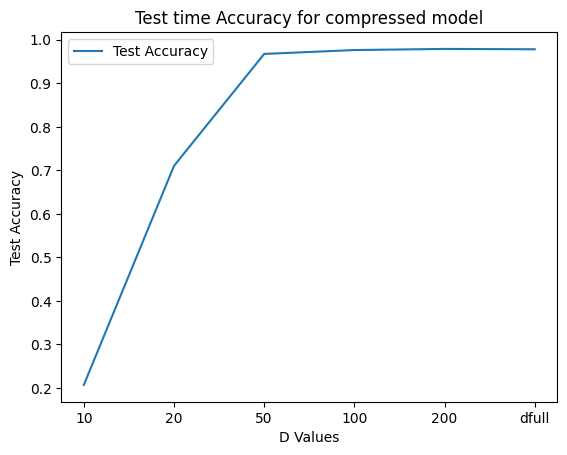

In [15]:
x_values = [10, 20, 50, 100, 200, 'dfull']

# Create a line plot
plt.plot(x_values, test_acc_list, label='Test Accuracy')


plt.xlabel('D Values')
plt.ylabel('Test Accuracy')
plt.title('Test time Accuracy for compressed model')

plt.legend()
plt.show()

## Load the Baseline Model and Dataset

Loading the dataset and preprocessing
Loading the baseline model from previous problem and testing

In [16]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images, test_images = train_images / 255.0, test_images / 255.0

baseline_model = load_model('/content/drive/MyDrive/MLops/models/baseline_model.h5')
baseline_model.summary()

test_loss, test_acc = baseline_model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │         803,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,012,492 (19.12 MB)

 Trainable params: 5,012,490 (19.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9756 - loss: 0.2597
Test accuracy: 0.979200005531311


## Compressing Baseline Model

### Performing Singular Value Decomposition

Performing SVD on Weight matrix obtained from each layer of Baseline Model and saving it in svd_dict

In [17]:
svd_dict = {}

for i in range(1,6):
  print('getting weights of Layer ', i)
  W, B = baseline_model.layers[i].get_weights()
  print('applying SVD on layer W of', i)
  s, u, v = tf.linalg.svd(W)
  print('reshaping s matrix')
  s = tf.linalg.diag(s)
  print('Shape of u matrix for layer ', i, u.shape)
  print('Shape of s matrix for layer ', i, s.shape)
  print('Shape of v matrix for layer ', i, v.shape)

  svd_dict['s_'+str(i)] = s
  svd_dict['u_'+str(i)] = u
  svd_dict['v_'+str(i)] = v
  svd_dict['B_'+str(i)] = B

getting weights of Layer  1
applying SVD on layer W of 1
reshaping s matrix
Shape of u matrix for layer  1 (784, 784)
Shape of s matrix for layer  1 (784, 784)
Shape of v matrix for layer  1 (1024, 784)
getting weights of Layer  2
applying SVD on layer W of 2
reshaping s matrix
Shape of u matrix for layer  2 (1024, 1024)
Shape of s matrix for layer  2 (1024, 1024)
Shape of v matrix for layer  2 (1024, 1024)
getting weights of Layer  3
applying SVD on layer W of 3
reshaping s matrix
Shape of u matrix for layer  3 (1024, 1024)
Shape of s matrix for layer  3 (1024, 1024)
Shape of v matrix for layer  3 (1024, 1024)
getting weights of Layer  4
applying SVD on layer W of 4
reshaping s matrix
Shape of u matrix for layer  4 (1024, 1024)
Shape of s matrix for layer  4 (1024, 1024)
Shape of v matrix for layer  4 (1024, 1024)
getting weights of Layer  5
applying SVD on layer W of 5
reshaping s matrix
Shape of u matrix for layer  5 (1024, 1024)
Shape of s matrix for layer  5 (1024, 1024)
Shape of 

### Compressing Baseline Model with D = 20

In [21]:
def compress_model(d):
  #d = 50

  compresed_model = models.Sequential()
  compresed_model.add(layers.Flatten(input_shape=(28, 28)))

  compressed_model_layer_index = 1

  for i in range(1, 6):
    compresed_model.add(layers.Dense(svd_dict['u_'+str(i)][:,:d].shape[1], use_bias=False))
    print('Layer ', compressed_model_layer_index, '(u) added to the compressed model' )
    print('Layer ', compressed_model_layer_index, ' u shape', svd_dict['u_'+str(i)][:,:d].shape)
    compresed_model.layers[compressed_model_layer_index].set_weights([svd_dict['u_'+str(i)][:,:d]])

    compressed_model_layer_index += 1
    compresed_model.add(layers.Dense(tf.transpose(svd_dict['v_'+str(i)][:,:d]).shape[1], activation='relu', use_bias=True))
    print('Layer ', compressed_model_layer_index, '(v) added to the compressed model' )
    print('Layer ', compressed_model_layer_index, ' v shape', tf.transpose(svd_dict['v_'+str(i)][:,:d]).shape)
    compresed_model.layers[compressed_model_layer_index].set_weights([svd_dict['s_'+str(i)][:d,:d] @ tf.transpose(svd_dict['v_'+str(i)][:,:d]), svd_dict['B_'+str(i)]])

    compressed_model_layer_index += 1

  compresed_model.add(layers.Dense(10, activation='softmax'))
  compresed_model.layers[compressed_model_layer_index].set_weights(baseline_model.layers[6].get_weights())
  print('Layer ', compressed_model_layer_index, 'added to model')
  learning_rate = 0.000005
  compresed_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return compresed_model

compresed_model_d20 = compress_model(20)
compresed_model_d20.summary()
test_loss, test_acc = compresed_model_d20.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc}")

Layer  1 (u) added to the compressed model
Layer  1  u shape (784, 20)
Layer  2 (v) added to the compressed model
Layer  2  v shape (20, 1024)
Layer  3 (u) added to the compressed model
Layer  3  u shape (1024, 20)
Layer  4 (v) added to the compressed model
Layer  4  v shape (20, 1024)
Layer  5 (u) added to the compressed model
Layer  5  u shape (1024, 20)
Layer  6 (v) added to the compressed model
Layer  6  v shape (20, 1024)
Layer  7 (u) added to the compressed model
Layer  7  u shape (1024, 20)
Layer  8 (v) added to the compressed model
Layer  8  v shape (20, 1024)
Layer  9 (u) added to the compressed model
Layer  9  u shape (1024, 20)
Layer  10 (v) added to the compressed model
Layer  10  v shape (20, 1024)
Layer  11 added to model


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_12 (Flatten)                 │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_157 (Dense)                    │ (None, 20)                  │          15,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_158 (Dense)                    │ (None, 1024)                │          21,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_159 (Dense)                    │ (None, 20)                  │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_160 (Dense)                    │ (None, 1024)                │          21,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_161 (Dense)                    │ (None, 20)                  │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_162 (Dense)                    │ (None, 1024)                │          21,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_163 (Dense)                    │ (None, 20)                  │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_164 (Dense)                    │ (None, 1024)                │          21,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_165 (Dense)                    │ (None, 20)                  │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_166 (Dense)                    │ (None, 1024)                │          21,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_167 (Dense)                    │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 215,370 (841.29 KB)

 Trainable params: 215,370 (841.29 KB)

 Non-trainable params: 0 (0.00 B)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6423 - loss: 1.0753
Test accuracy: 0.6832000017166138


### Train Compressed Model

In [22]:
compresed_model_d20.fit(train_images, train_labels, epochs=20, validation_split=0.1)

Epoch 1/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8379 - loss: 0.5651 - val_accuracy: 0.9498 - val_loss: 0.2035
Epoch 2/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9503 - loss: 0.1925 - val_accuracy: 0.9612 - val_loss: 0.1699
Epoch 3/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9601 - loss: 0.1536 - val_accuracy: 0.9670 - val_loss: 0.1512
Epoch 4/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9666 - loss: 0.1277 - val_accuracy: 0.9710 - val_loss: 0.1419
Epoch 5/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9695 - loss: 0.1159 - val_accuracy: 0.9730 - val_loss: 0.1336
Epoch 6/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9711 - loss: 0.1033 - val_accuracy: 0.9735 - val_loss: 0.1284
Epoch 7/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9704 - loss: 0.1045 - val_accuracy: 0.9748 - val_loss: 0.1257
Epoch 8/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9722 - loss: 0.0958 

### Test Retrained Compressed Model

In [23]:
test_loss, test_acc = compresed_model_d20.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9731 - loss: 0.1404
Test accuracy: 0.9768999814987183


## Inference

The baseline model achieved a test accuracy of 98.26%, with the total of 5,012,490 parameters.

On the other hand, the compressed model with a factor D set to 20 achieves a test accuracy of 97.37%, indicating a slight decrease in accuracy compared to the baseline. However, this model boasts a significantly reduced parameter count, with only 215,370 parameters which shows that most of the parameters in baseline model where redundant
